In [ ]:
import numpy # used for vector/tensor operations
import torch # used for vector/tensor operations
import torch.distributions # used for sampling

# globals
DIM = 4*3
POPULATION_SIZE = 15
#MUTATION_RATE = 0.05
MUTATION_RATE = 0.05
TAU_PRIME = 0.34
TAU = 0.5

# TAU_PRIME = 1/numpy.sqrt(2*numpy.sqrt(DIM))
# TAU = 1/numpy.sqrt(2*DIM)

LAMBDA = 100
MU = POPULATION_SIZE
CROSSOVER_RATE = 0.0
NUM_GENERATIONS = 100
PROBLEM_NAME = "Iris"
GA_ES = "ES"

(100, 4) := X
(4, 3) := W
Y = XW

W = (X^T X)^(-1) XY

Y := (100, 3)

In [ ]:
def ES_Population_Init(population_size, low=-10, high=10):
    """
    randomly intializes a population of population_size with
    each individual stored a real number between -10 and 10
    """

    # creates a uniform distributions with a batch_size of num_genes
    # which samples between -10 and 10.
    dist = torch.distributions.Uniform(torch.full((DIM,), -10.0), torch.full((DIM,), 10.0))

    # takes population_size samples from the distribution
    points = dist.sample((population_size,))

    # initalizes stds to 1.0
    stds = torch.ones((population_size, DIM))

    # returns population
    return torch.cat((points, stds), dim=1)


def Iris_Fitness(population, X_train, y_train):
    """
    computes the accuracy on iris for each member of the population
    and returns a 1D tensor tensor with all these values
    """

    #logits = numpy.matmul(population[:, :DIM].reshape(-1, 4), X_train.T)

    logits = numpy.matmul(population[:, :DIM].reshape(-1, 3, 4), X_train.T)

    #print(logits.shape)

    #logits = logits.reshape(-1, 3, X_train.shape[0])

    predictions = numpy.argmax(logits, axis=1)

    #print(predictions.shape)

    #print(y_train.shape)

    accuracy = numpy.equal(predictions, y_train)

    #print(accuracy)

    accuracy = torch.mean(accuracy.float(), dim=1)

    # returns fitness
    return accuracy


def ES_Himmelblau_Fitness(population):
    """
    computes the Himmelblau fitness for each member of the population
    and returns a 1D tensor tensor with all this values
    """

    # get x and y from the population
    x = population[:, 0]
    y = population[:, 1]

    # calculates the Himmelblau fitness
    himmelblau = (x**2 + y - 11)**2 + (x + y**2 - 7)**2

    # returns fitness
    return -himmelblau


def Calculate_Fitness(population, X_train, y_train):
    """
    calls a function to calculate fitness
    used to make it easy to switch out the fitness function
    """
    return Iris_Fitness(population, X_train, y_train)


def ES_Mutate(population, tau_prime, tau, epsilon=0.01, mutation_rate=1.0):
    """
    mutates the population
    as per the book/HW, we assume that the mutation_rate is 1.0
    """
    # creates a normal distribution with mean 0.0 and std 1.0
    dist = torch.distributions.Normal(0.0, 1.0)

    # individual wide samples
    individual_samples = dist.sample((population.shape[0], 1))

    # gene specific samples
    gene_samples = dist.sample((population.shape[0], DIM))

    # updates stds
    population[:, DIM:] *= torch.exp(tau_prime * individual_samples + tau * gene_samples)

    # increase stds that are too small to be equal to epsilon
    population[:, DIM:][population[:, DIM:] < epsilon] = epsilon

    # update points
    population[:, :DIM] += population[:, DIM:] * gene_samples

    # returns population
    return population


def ES_Population_Make_New_Generation(population):
    """
    samples parents, recombines parents to create children, mutates children,
    and selects new generation
    """
    # calculates uniform probabilities for parents
    uniform_probs = torch.full((population.shape[0],), 1/population.shape[0])

    # distribution used to select parents
    parent_selection_dist = torch.distributions.Categorical(probs=uniform_probs)

    # get parent indices
    parent_idx = parent_selection_dist.sample((LAMBDA,))

    # get parents
    parents = population[parent_idx]

    # creates children with intermediate recombination.
    # I am using intermediate recombination over discrete recombination
    # since intermediate recombination can select values for the child that
    # are not contained in any parent. I thought that this might be helpful
    # when looking at the loss landscape.
    # Additionally, there is a note an page 65 of the textbook indicating the 
    # intermediate selection tends to work well with self-adaptation.
    # each pair of parents creates two children.
    children = torch.zeros_like(parents)

    for i in range(0, parents.shape[0]-1, 2):
        # create first child
        crossover = numpy.random.uniform() < CROSSOVER_RATE

        # note that I use two different alpha values and sample alpha from
        # a normal distribution. This is slightly different than what the book does
        # but I though that this could be helpful and provide more diversity.
        if crossover:
            alpha_1 = numpy.random.uniform()
            child1 = alpha_1 * parents[i] + (1 - alpha_1) * parents[i+1]
        else:
            child1 = parents[i]

        # create second child
        crossover = numpy.random.uniform() < CROSSOVER_RATE

        if crossover:
            alpha_2 = numpy.random.uniform()
            child2 = alpha_2 * parents[i] + (1 - alpha_2) * parents[i+1]
        else:
            child2 = parents[i+1]

        # store children
        children[i], children[i+1] = child1, child2

    # mutate children
    children = ES_Mutate(children, TAU_PRIME, TAU)

    # select next generation with (mu, lambda) selection.
    # I am using this type of selection, since the book has
    # a note on page 89 saying that (mu, lambda) selection
    # is preferred for Evolutionary Strategies. 
    # The most relavent section from the book seems to be
    # "(mu + lambda) selection hinders the self-adaptation mechanism
    # to adapt strategy parameters."
    sorted_children = sorted(children[:, None, :], key=lambda x: Calculate_Fitness(x, X_train, y_train).item())
    next_gen = sorted_children[-population.shape[0]:]

    return torch.cat(next_gen)


def ES_Diversity(population):
    """
    calculates the diversity of the population as the
    Euclidian distance between the members of the population
    that are furthest apart in GENOME SPACE
    """
    max_dist = 0.0

    for i in range(population.shape[0]):
        for j in range(population.shape[0]):
            dist = torch.sqrt(torch.sum((population[i] - population[j])**2)).item()

            if dist > max_dist:
                max_dist = dist

    return max_dist

In [ ]:
def Calculate_Iris_Ensemble_Fitness(population, X_train, y_train):
  """
  Combines individual prediction to make ensemble prediction
  """

  # logits for the individuals
  logits = numpy.matmul(population[:, :DIM].reshape(-1, 3, 4), X_train.T)

  # predictions for the individuals
  predictions = numpy.argmax(logits, axis=1)

  #print(predictions)
  #print(predictions.shape)

  # ensemble predictions
  ensemble_predictions = torch.mode(predictions, dim=0)[0]

  # calculate ensemble accuracy
  accuracy = numpy.equal(ensemble_predictions, y_train)

  accuracy = torch.mean(accuracy.float())

  # returns fitness
  return accuracy

In [ ]:
from sklearn import datasets
from sklearn.utils import shuffle

In [ ]:
# load in data
iris = datasets.load_iris()

X = iris.data[:100]
y = iris.target[:100]

# X = iris.data
# y = iris.target

In [ ]:
NUM_RUNS = 1000
NOISE = 0.25
SHIFT = 0.25

if __name__ == '__main__':
  dist = torch.distributions.normal.Normal(loc=torch.zeros(4), scale=torch.ones(4))

  baseline_accuracy = []
  ensemble_accuracy = []
  train_max_accuracy = [ [] for _ in range(NUM_RUNS) ]
  train_average_accuracy = [ [] for _ in range(NUM_RUNS) ]

  for i in range(NUM_RUNS):
    # shuffle data
    X, y = shuffle(X, y)
    noise = dist.sample((25,)) * NOISE
    shift = dist.sample() * SHIFT

    # split into train and test
    X_train = X[:75]
    X_test = X[75:] + numpy.array(noise) + numpy.array(shift)

    y_train = y[:75]
    y_test = y[75:]

    max_fitnesses = [[], [], []]
    average_fitnesses = [[], [], []]

    # initializes the population
    population_1 = ES_Population_Init(POPULATION_SIZE, -30, -10)
    population_2 = ES_Population_Init(POPULATION_SIZE, -10, 10)
    population_3 = ES_Population_Init(POPULATION_SIZE, 10, 30)

    populations = [population_1, population_2, population_3]

    # used for comvergence termination
    # terminate = (torch.max(Calculate_Fitness(population, X_train, y_train)), 0)

    # training loop
    for generation_count in range(NUM_GENERATIONS):
        # calculates population statistics
        max_fitness = [torch.max(Calculate_Fitness(population, X_train, y_train)).item() for population in populations]
        average_fitness = [float(torch.mean(Calculate_Fitness(population, X_train, y_train))) for population in populations]

        #train_max_accuracy[i].append(max_fitness.item())
        #train_average_accuracy[i].append(average_fitness)

        # prints population statistics
        if generation_count == 0:
            print(f"{PROBLEM_NAME} {GA_ES} {MU} {LAMBDA} {TAU} {CROSSOVER_RATE} {generation_count} {generation_count*100} {max_fitness} {average_fitness}")

        # exchange information
        if generation_count % 25 == 0:
          i = numpy.random.randint(0, MU)

          pop_1 = populations[0][i].clone()
          pop_2 = populations[1][i].clone()
          pop_3 = populations[2][i].clone()

          populations[0][i] = pop_3
          populations[1][i] = pop_1
          populations[2][i] = pop_2

        # creates new generation
        for i in range(len(populations)):
          populations[i] = ES_Population_Make_New_Generation(populations[i])

        # append to lists
        max_fitnesses.append(max_fitness)
        average_fitnesses.append(average_fitness)

        # prints population statistics
        # print(f"{generation_count} {max_fitness} {average_fitness}")

        # handles termination
        if generation_count == NUM_GENERATIONS-1:
            print(f"{i} Generational Bound Reached")
            break
        #elif ((max_fitnesses-terminate[0])/(abs(terminate[0])+1e-5)) < 0.02:
            #terminate = (terminate[0], terminate[1]+1)

            # if we haven't improve at least 2% in the last
            # 20 generations then terminate
            #if terminate[1] >= 20:
              #pass
                #print("Convergence Termination")
                #break
        #else:
            #terminate = (max_fitnesses, 0)

    print(f"{PROBLEM_NAME} {GA_ES} {MU} {LAMBDA} {TAU} {CROSSOVER_RATE} {generation_count} {generation_count*100} {max_fitness} {average_fitness}")

    # calculate test performance
    #population = populations[0] + populations[1] + populations[2]

    #populations[0] = sorted(populations[0][:, None, :], key=lambda x: Calculate_Fitness(x, X_train, y_train).item())[-5:]
    #populations[1] = sorted(populations[1][:, None, :], key=lambda x: Calculate_Fitness(x, X_train, y_train).item())[-5:]
    #populations[2] = sorted(populations[2][:, None, :], key=lambda x: Calculate_Fitness(x, X_train, y_train).item())[-5:]

    #population = torch.cat((populations[0] + populations[1] + populations[2]))
    #population = populations[0] + populations[1] + populations[2]

    population = torch.cat((populations[0], populations[1], populations[2]))

    print(population.shape)

    best_idx = torch.argmax(Calculate_Fitness(population, X_train, y_train))
    best = population[best_idx]

    best_acc = Calculate_Fitness(best[None], X_test, y_test)

    baseline_accuracy.append(best_acc.item())

    ensemble_acc = Calculate_Iris_Ensemble_Fitness(population, X_test, y_test)

    ensemble_accuracy.append(ensemble_acc.item())

Iris ES 15 100 0.5 0.0 0 0 [0.5199999809265137, 0.5199999809265137, 0.5199999809265137] [0.23466666042804718, 0.2639999985694885, 0.3448888659477234]
2 Generational Bound Reached
Iris ES 15 100 0.5 0.0 99 9900 [1.0, 1.0, 1.0] [1.0, 1.0, 1.0]
torch.Size([45, 24])
Iris ES 15 100 0.5 0.0 0 0 [0.8666666746139526, 0.5733333230018616, 0.653333306312561] [0.35822221636772156, 0.25866666436195374, 0.35466668009757996]
2 Generational Bound Reached
Iris ES 15 100 0.5 0.0 99 9900 [1.0, 1.0, 1.0] [1.0, 1.0, 1.0]
torch.Size([45, 24])
Iris ES 15 100 0.5 0.0 0 0 [0.54666668176651, 0.54666668176651, 1.0] [0.2808889150619507, 0.3128889203071594, 0.4320000112056732]
2 Generational Bound Reached
Iris ES 15 100 0.5 0.0 99 9900 [1.0, 1.0, 1.0] [1.0, 1.0, 1.0]
torch.Size([45, 24])
Iris ES 15 100 0.5 0.0 0 0 [0.5199999809265137, 0.5066666603088379, 0.5066666603088379] [0.37511110305786133, 0.3333333432674408, 0.3733333349227905]
2 Generational Bound Reached
Iris ES 15 100 0.5 0.0 99 9900 [1.0, 1.0, 1.0] [1.0

In [ ]:
print(train_max_accuracy)
print(train_average_accuracy)

[[], [], [], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [], [], [], []]


In [ ]:
import csv

file_name = 'Experiment_1_train_max_accuracy.csv'

with open(file_name, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(train_max_accuracy)

file_name = 'Experiment_1_train_average_accuracy.csv'

with open(file_name, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(train_average_accuracy)

In [ ]:
train_max_accuracy = torch.Tensor(train_max_accuracy)
train_average_accuracy = torch.Tensor(train_average_accuracy)

print(train_max_accuracy.shape)

max_avg = torch.mean(train_max_accuracy, dim=0)
max_std = torch.std(train_max_accuracy, dim=0)
average_avg = torch.mean(train_average_accuracy, dim=0)
average_std = torch.std(train_average_accuracy, dim=0)

torch.Size([1000, 100])


In [ ]:
print(max_std)

tensor([0.1309, 0.0504, 0.0671, 0.0792, 0.0916, 0.0991, 0.1072, 0.1088, 0.1143,
        0.1102, 0.1096, 0.1111, 0.1118, 0.1107, 0.1104, 0.1086, 0.1090, 0.1085,
        0.1090, 0.1082, 0.1070, 0.1040, 0.1036, 0.1027, 0.1035, 0.1018, 0.1038,
        0.1017, 0.1023, 0.0993, 0.1001, 0.0997, 0.0998, 0.0998, 0.0997, 0.0998,
        0.0999, 0.0976, 0.0979, 0.0964, 0.0953, 0.0950, 0.0951, 0.0952, 0.0951,
        0.0953, 0.0952, 0.0953, 0.0950, 0.0950, 0.0953, 0.0953, 0.0954, 0.0953,
        0.0953, 0.0954, 0.0954, 0.0955, 0.0956, 0.0958, 0.0958, 0.0956, 0.0957,
        0.0957, 0.0958, 0.0957, 0.0958, 0.0958, 0.0959, 0.0960, 0.0960, 0.0960,
        0.0960, 0.0961, 0.0960, 0.0960, 0.0961, 0.0961, 0.0961, 0.0961, 0.0961,
        0.0961, 0.0960, 0.0961, 0.0961, 0.0961, 0.0962, 0.0962, 0.0963, 0.0963,
        0.0963, 0.0963, 0.0964, 0.0964, 0.0965, 0.0956, 0.0943, 0.0945, 0.0949,
        0.0948])


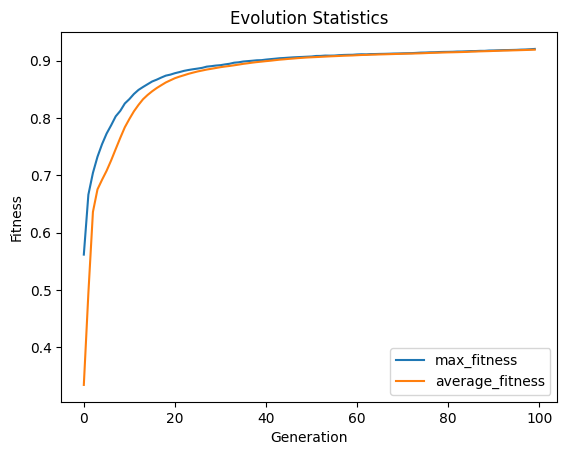

In [ ]:
import matplotlib.pyplot as plt

plt.plot(max_avg, label="max_fitness")
# plt.fill_between(list(range(0,100)), (max_avg - max_std/2), (max_avg + max_std/2), alpha=0.2)
plt.plot(average_avg, label="average_fitness")
# plt.fill_between(list(range(0,100)), (average_avg - average_std/2), (average_avg + average_std/2), alpha=0.2)
plt.title("Evolution Statistics")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.legend(loc="lower right")
plt.savefig('Experiment1_evolution_statistics.png', dpi=1200)

In [ ]:
print(baseline_accuracy)
print(ensemble_accuracy)

[1.0, 0.9200000166893005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8399999737739563, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9200000166893005, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7200000286102295, 0.800000011920929, 0.7599999904632568, 1.0, 1.0, 0.8399999737739563, 0.9200000166893005, 0.9599999785423279, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8399999737739563, 1.0, 1.0, 0.9599999785423279, 1.0, 0.9200000166893005, 1.0, 1.0, 0.9200000166893005, 1.0, 1.0, 0.8799999952316284, 1.0, 0.9599999785423279, 1.0, 0.9599999785423279, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 0.9599999785423279, 1.0, 0.9200000166893005, 0.9200000166893005, 1.0, 0.9200000166893005, 1.0, 1.0, 1.0, 0.9599999785423279, 0.7200000286102295, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8399999737739563, 1.0, 1.0, 1.0, 0.9599999785423279, 0.9200000166893005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9200000166893005, 1.0, 0.8399

In [ ]:
print(numpy.mean(baseline_accuracy))
print(numpy.mean(ensemble_accuracy))

0.9688399966359138
0.9880399978756904


In [ ]:
import csv

file_name = 'iris_baseline_full_experiment_5_2classes.csv'

with open(file_name, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(baseline_accuracy)

print(baseline_accuracy)

[]


In [ ]:
import csv

file_name = 'iris_ensemble_full_experiment_5_2classes.csv'

with open(file_name, 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(ensemble_accuracy)

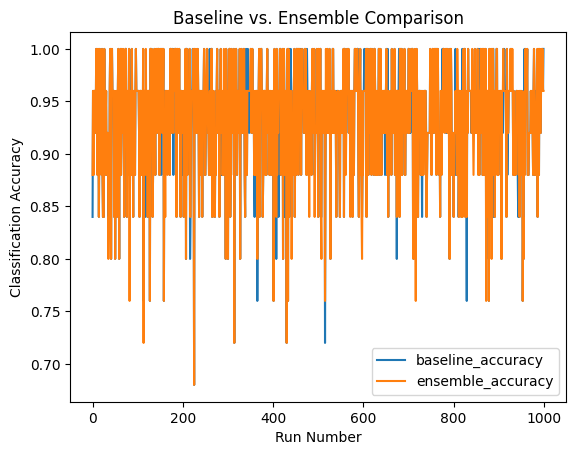

In [ ]:
import matplotlib.pyplot as plt

plt.plot(baseline_accuracy, label="baseline_accuracy")
# plt.fill_between(list(range(0,100)), (max_avg - max_std/2), (max_avg + max_std/2), alpha=0.2)
plt.plot(ensemble_accuracy, label="ensemble_accuracy")
# plt.fill_between(list(range(0,100)), (average_avg - average_std/2), (average_avg + average_std/2), alpha=0.2)
plt.title("Baseline vs. Ensemble Comparison")
plt.ylabel("Classification Accuracy")
plt.xlabel("Run Number")
plt.legend(loc="lower right")
plt.savefig('Experiment3_comparison_shift.png', dpi=1200)

In [56]:
import csv

with open('iris_baseline_full_experiment_5_noise_shift_2classes.csv', newline='') as f:
    reader = csv.reader(f)
    baseline = list(reader)
    baseline = [float(x) for x in baseline[0]]

with open('iris_ensemble_full_experiment_5_noise_shift_2classes.csv', newline='') as f:
    reader = csv.reader(f)
    ensemble = list(reader)
    ensemble = [float(x) for x in ensemble[0]]

In [57]:
print(ensemble)
print(baseline)

[1.0, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 0.9599999785423279, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8799999952316284, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9599999785423279, 1.0, 0.8399999737739563, 1.0, 1.0, 1.0, 1.0, 0.9200000166893005, 1.0, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9599999785423279, 1.0, 0.8399999737739563, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9599999785423279, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9599999785423279, 0.7599999904632568, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9200000166893005, 1.0, 1.0, 1.0, 0.9200000166893005, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9599999785423279, 0.9599999785423279, 1.0, 0.8799999952316284, 1.0, 1.0, 0.92000001

In [58]:
import numpy as np

print(np.mean(ensemble))
print(np.mean(baseline))

0.9880399978756904
0.9688399966359138


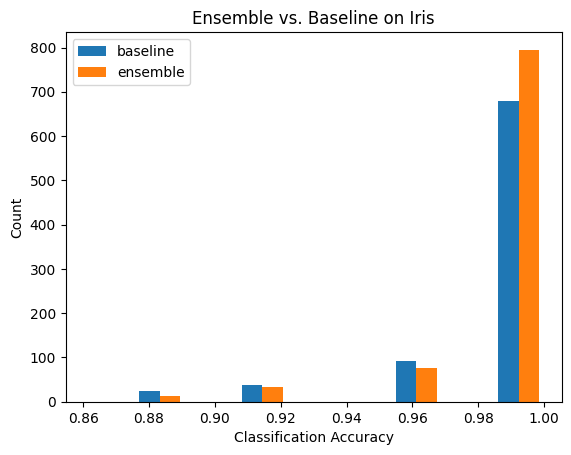

In [54]:
import matplotlib.pyplot as plt

bins = numpy.linspace(0.86, 1.0, 10)

plt.hist([baseline, ensemble], bins=bins, label=["baseline", "ensemble"])
# plt.hist(baseline, label="baseline", alpha=1.0)
# plt.hist(ensemble, label="ensemble", alpha=0.85)
plt.legend(loc="upper left")
plt.title("Ensemble vs. Baseline on Iris")
plt.ylabel("Count")
plt.xlabel("Classification Accuracy")
plt.savefig('Experiment5_comparison_noise_shift_full_hist.png', dpi=1200)

In [ ]:
from google.colab import files
files.download('Experiment5_comparison_noise_shift_full_hist.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
from scipy import stats
import numpy as np

print(baseline)
print(ensemble)

t_check = stats.ttest_ind(ensemble, baseline)
t_check
alpha=0.05

print(np.mean(baseline))
print(np.mean(ensemble))

print(t_check)
print(t_check[1])

[1.0, 0.9200000166893005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8399999737739563, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9200000166893005, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7200000286102295, 0.800000011920929, 0.7599999904632568, 1.0, 1.0, 0.8399999737739563, 0.9200000166893005, 0.9599999785423279, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8399999737739563, 1.0, 1.0, 0.9599999785423279, 1.0, 0.9200000166893005, 1.0, 1.0, 0.9200000166893005, 1.0, 1.0, 0.8799999952316284, 1.0, 0.9599999785423279, 1.0, 0.9599999785423279, 1.0, 0.9599999785423279, 1.0, 1.0, 1.0, 0.9599999785423279, 1.0, 0.9200000166893005, 0.9200000166893005, 1.0, 0.9200000166893005, 1.0, 1.0, 1.0, 0.9599999785423279, 0.7200000286102295, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8399999737739563, 1.0, 1.0, 1.0, 0.9599999785423279, 0.9200000166893005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9200000166893005, 1.0, 0.8399